<a href="https://colab.research.google.com/github/jacobadodge/Spring2024_CVENG_8160/blob/main/Submittal_HW01_Dodge_Jacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions
***Assignment Details:***
You are provided with two datasets: localization and classification.
Localization: provides images and a csv file describing the location of objects in each image.
Classification: provides images collated in folders which describe the type of vehicle classes the images belong to. To complete this assignment:

***Download and extract both datasets:***
Use object oriented programming to write a custom data loader to read and transform both datasets. Note that localization will need labels to be transformed also.
The transforms to use should include: resizing of images, horizontal, vertical flip, tensor and normalization of data.
Include custom plotting functions to help visualize data.
***Rules:***
Feel free to use online resources. However, if you use any function or technique not discussed in class, demonstrate your understanding of the technique with at least 2 examples of how to use the function. You will lose points if this is not done
***Use google collab only***
While you may discuss this homework with your colleagues, your solution should not look too similar to others. You will be penalized for that.

##Preliminary Plan
1. Create a class to hold all of the functions
2. Create function to process each dataset (tuple in form of {'image': image_data, 'label': image_label})
3. Write functions to transform the images (resize, flip, tensor, normalization...?)
4. Write function to visualize images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01'

/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01


In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader # 'dataset' used to represent a dataset; 'dataloader' used to load batches of data for training and testing
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import cv2
from google.colab.patches import cv2_imshow

plt.ion()   # interactive mode

##Process Image Data and Creating Classes

In [170]:
# class to process images from classification folders
class Images():

  def __init__(self, class_root_dir):  # root_dir is root directory (where data is stored)
# initialize dataset variables here
      self.class_root_dir = Path(class_root_dir)  # where the 'classificaiton' data resides
      self.class_df = pd.DataFrame(columns = ['image_names','class_label']) # define column headers of classification data frame
      self.local_df = pd.DataFrame(columns = ['image_names'])  # define column headers of localization data frame

# collect images from 'classification' data folder
      for fldr in self.class_root_dir.iterdir():  # self.root is root directory; iterdir() means loop through the folders and files in that directory
        class_img_names = []  #create empty list to append image names from root directory folders to
        if fldr.is_dir(): # if the current 'fldr' is a directory (a folder, not a file):
          class_img_names = class_img_names + list(fldr.glob('*.jpg'))  # .glob('.jpg') puts together the files with the extension '*.ppm'; the *.ppm files are then added to the 'img_names' list
        class_df_cur = pd.DataFrame(class_img_names,columns = ['image_names'])  # create dataframe with one column 'image_names' w/ the data in that column being 'class_img_names'
        class_df_cur['class_label'] = fldr.name # .name strips the file path and just shows the folder name in a new column named 'class_label'
        self.class_df = pd.concat([self.class_df, class_df_cur],axis=0, ignore_index = True) # combine 'self.class_df' with 'class_df_cur' along the rows (axis 0)

# shuffle the dataframe
      self.df = self.class_df
      self.df = self.df.sample(frac=1)
      self.df = pd.DataFrame(self.df)

# group the images from the 'local' folder and 'classificaiton' folder together
      self.image_names = list(self.df['image_names'].values)
      self.class_label = list(self.df['class_label'].values)

  def __len__(self):  # dont call len but program will run it
      # returns the length of the dataset
      return len(self.image_names)

  def __getitem__(self, idx): # dont call getitem but program will run it

      # preprocess and transformations
      # indexes the dataset such that dataset[i] can retrieve the ith sample.
      image = self.image_names[idx]
      image_data = io.imread(image) # read the image
      # image_np = Image.fromarray(image_data)

      label = self.image_names[idx].name.replace('.jpg', ' ')

      sample = {'image': image_data, 'label': label}  # return a tuple of 'image' which is the image data and 'label' which is the image name

      return sample # whenever getitem is called for a certain index it will return an image and a label




# class to flip images
class Flip():

  def __init__(self, type_of_flip):
    assert isinstance(type_of_flip, int)
    self.type_of_flip = type_of_flip

  def __call__(self, sample): # automatically ran (don't need to call it)
        image, labels = sample['image'], sample['label']

        new_img = np.flip(image, self.type_of_flip)
        return {'image': new_img, 'label': labels}




# class to rescale images
class Rescale(Images):

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample): # automatically ran (don't need to call it)
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int): # rescale images based on user input
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w) # make sure image size is integers (not floats)

        img = transform.resize(image, (new_h, new_w)) # imported module that transform/resize image

        return {'image': img, 'label': labels}  # return data of image and image label/name




# class to transform data to tensor
class Tensor():

  def __init__(self, image):
    self.image = image

  def __call__(self):
    image, labels = self.image['image'], self.image['label']
    image = np.transpose(image, (2, 0, 1))
    image = torch.from_numpy(image)
    return {'image': image, 'label': labels}




# class to process images from localization folder
class Locate():

  def __init__(self, local_root_dir, image):
    self.local_root_dir = Path(local_root_dir)
    self.image = image
    self.local_df = pd.DataFrame(columns = ['image_names'])

# process images from the localization folders
    for fldr in self.local_root_dir.iterdir():
        local_img_names = []
        if fldr.is_dir():
          local_img_names = local_img_names + list(fldr.glob('*.jpg'))
        local_df_cur = pd.DataFrame(local_img_names, columns = ['image_names'])
        self.local_df = pd.concat([self.local_df, local_df_cur])
        self.local_df['img_name'] = self.local_df['image_names'].apply(lambda x: int(x.name.split('.')[0].replace('image', '')))  # make the 'img_name' in self.local_df just the image number, no file path

    localize_df = pd.read_csv('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01/localize/train.csv') # create data frame from csv file

    img_x1_dict = {}  # create dictionary where the key is the img_name (which is the image number) and the value is the x1 coordinate of the localizing frame for that image
    for index, row in localize_df.iterrows(): # itterate over all rows of the data frame
      img_name = row['img_name']  # create variable named 'img_name' which is the value from the column 'img_name' in localize_df
      x1_value = row['x1']  # create variable named 'x1_value' whic is the value from teh column 'x1' in localize_df
      img_x1_dict[img_name] = x1_value  # add the value for the variable 'img_name' to the dictionary 'img_x1_dict' as a key with the value pair being the value for variable 'x1_value'

    img_y1_dict = {} # create dictionary where the key is the img_name (which is the image number) and the value is the y1 coordinate of the localizing frame for that image
    for index, row in localize_df.iterrows():
      img_name = row['img_name']
      y1_value = row['y1']
      img_y1_dict[img_name] = y1_value

    img_x2_dict = {}  # create dictionary where the key is the img_name (which is the image number) and the value is the x2 coordinate of the localizing frame for that image
    for index, row in localize_df.iterrows():
      img_name = row['img_name']
      x2_value = row['x2']
      img_x2_dict[img_name] = x2_value

    img_y2_dict = {}  # create dictionary where the key is the img_name (which is the image number) and the value is the y2 coordinate of the localizing frame for that image
    for index, row in localize_df.iterrows(): # itterate over all rows of the data frame
      img_name = row['img_name']
      y2_value = row['y2']
      img_y2_dict[img_name] = y2_value

    for img_name, value in img_x1_dict.items():
      self.local_df.loc[self.local_df['img_name'] == img_name, 'x1'] = value  # locate rows where 'img_name' in the data frame == 'img_name' key from the dictionary and set the 'x1' value for this row as the value from the

    for img_name, value in img_y1_dict.items():
      self.local_df.loc[self.local_df['img_name'] == img_name, 'y1'] = value

    for img_name, value in img_x2_dict.items():
      self.local_df.loc[self.local_df['img_name'] == img_name, 'x2'] = value

    for img_name, value in img_y2_dict.items():
      self.local_df.loc[self.local_df['img_name'] == img_name, 'y2'] = value




# class to visualize an image with the object enclosed by a rectangle
  def locate_visual(self):
    row = self.local_df.iloc[self.image]  # locate the index in the dataframe 'self.local_df' that matches 'self.image'
    img = cv2.imread(str(row['image_names'])) # find the file path to the image of interest from the 'self.local_df' data frame
    x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
    x1 = int(x1)  # convert the values for the rectange coordinates to integers
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Change color and thickness as needed
    cv2_imshow(img)

In [187]:
obj = Images('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01/classification/data')

#Example of classification functions in use

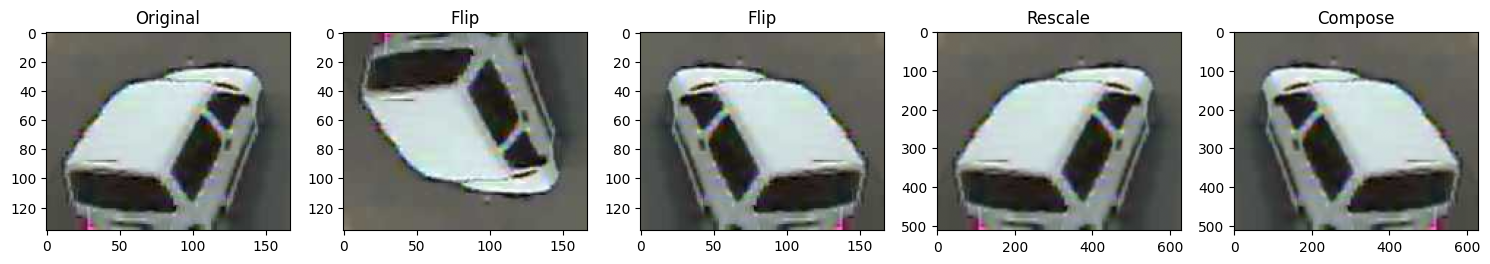

In [188]:
fig = plt.figure(figsize=(15,15)) # set image sizes to be visualized

ax = plt.subplot(1, 5, 1) # create subplot of 1 row, 5 columns, and tell following code to visualizei in column 1
plt.imshow(obj[60]['image']) # put original image on subplot column 1
ax.set_title('Original')  # title original image 'Original'

cmps = transforms.Compose([Flip(1), Rescale(512)]) # perform a flip and rescale at the same time
for i, trnsfm in enumerate([Flip(0), Flip(1), Rescale(512), cmps]): # itterate through list containing multiple functions to transform an image
  transformed_data = trnsfm(obj[60])['image']  # apply functions from list to the image ( equivalent to: 'Flip(0)(obj[60])['image']' )
  ax = plt.subplot(1, 5, i+2) # tell current itteration where to plot on subplot
  plt.imshow(transformed_data)  # visualize the current itteration
  plt.tight_layout()  # make sure all images fit on the screen at once
  ax.set_title(type(trnsfm).__name__) #  set the title of the visualization to the name of the applied function

image_compose = cmps(obj[60])['image']
final_transformed_img = Tensor(image_compose)


#Example of localization function in use

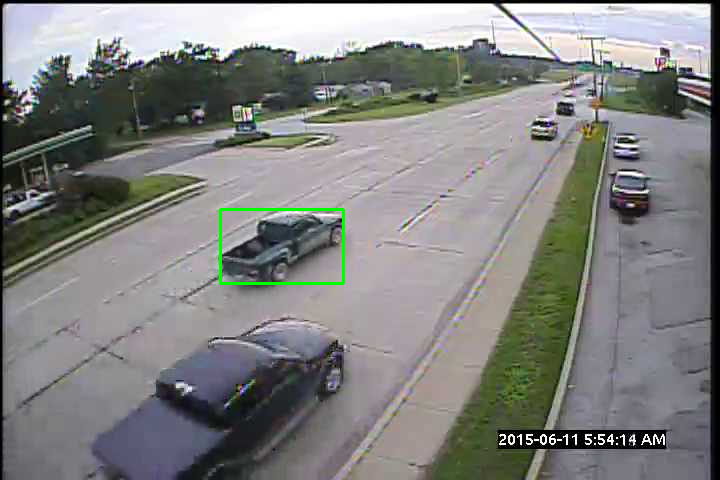

In [196]:
trial = Locate('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01/localize', 120)
trial.locate_visual()

# I tried making one data loader for both folders and struggled with it for hours so i decided it was best to atleast show my functions in actioin